In [ ]:
!pip install segmentation_models

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from tensorflow import keras
import tensorflow as tf

Segmentation Models: using `tf.keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
img_folder_path_coronary = "/content/gdrive/MyDrive/ProCom/Images/Coronary_Angiography_all/Original"
img_folder_path = "/content/gdrive/MyDrive/ProCom/Images/Combined_Data/Original"


img_folder_path_fundus = "/content/gdrive/MyDrive/ProCom/Images/DataSet_etiquete/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Original"


In [ ]:
train_img = np.sort(os.listdir(f'{img_folder_path_coronary}'))

test_img = np.sort(os.listdir(f'{img_folder_path_coronary}'))

test = np.sort(os.listdir(f'{img_folder_path}'))


FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/ProCom/Images/DataSet_etiquete/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Original/0.png'

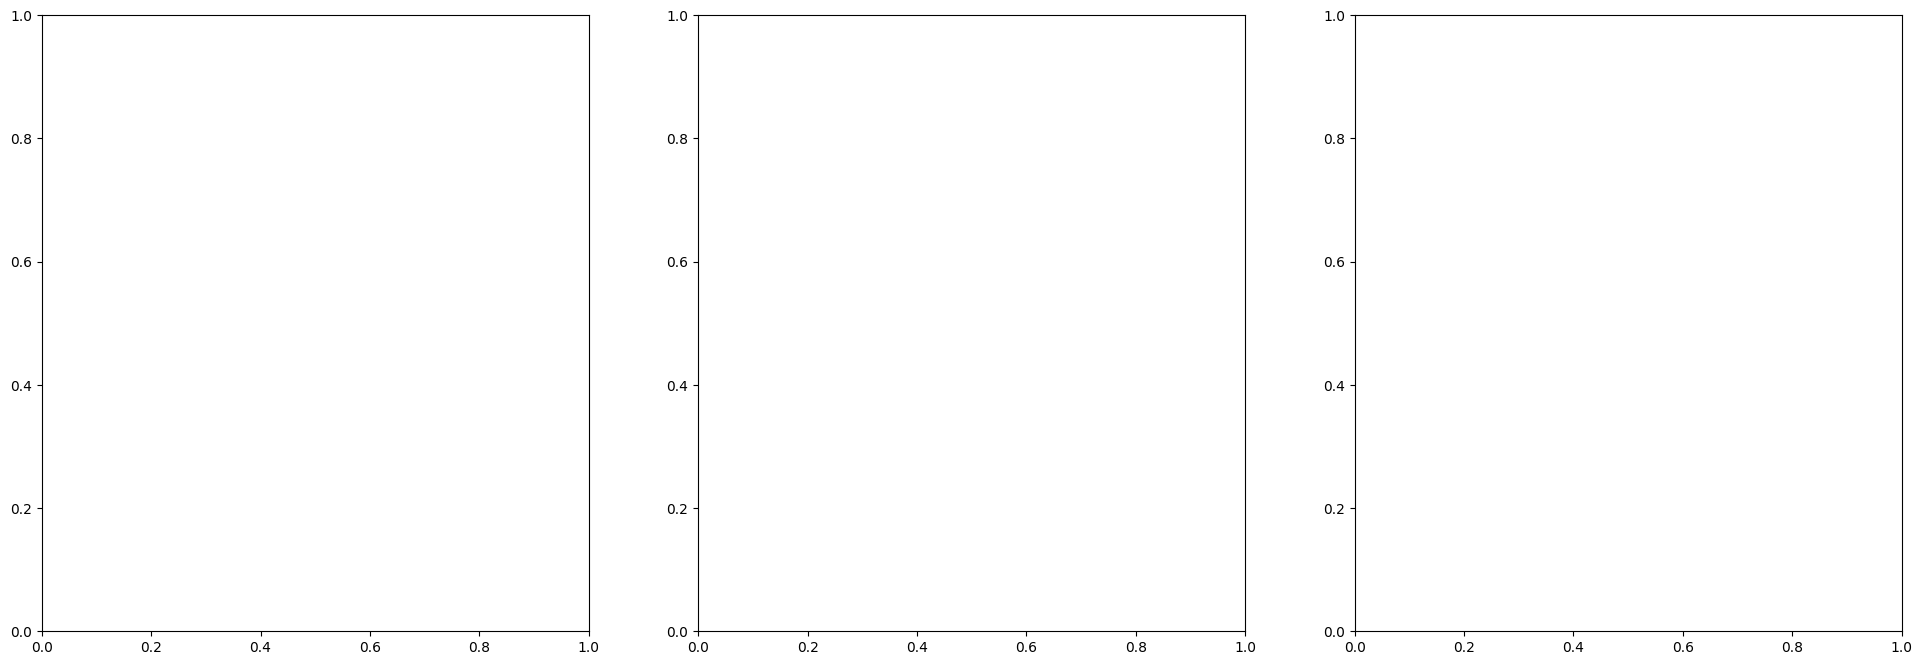

In [ ]:

ig, ax= plt.subplots(1,3, figsize=(24,8))
for j in range(3):
        ax[j].imshow(plt.imread(f'{img_folder_path_fundus}/{train_img[j]}'))
        ax[j].set_title(train_img[j][-7:])

##Denoising using a classical approach NLM: Non-Local Means

In [ ]:
noisy_image = cv2.imread(f'{img_folder_path_fundus}/{train_img[0]}', cv2.IMREAD_COLOR)
denoised_image = cv2.fastNlMeansDenoisingColored(noisy_image)

fig, ax= plt.subplots(1,2, figsize=(24,12))
ax[0].imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB))

error: OpenCV(4.8.0) /io/opencv/modules/photo/src/denoising.cpp:178: error: (-5:Bad argument) Type of input image should be CV_8UC3 or CV_8UC4! in function 'fastNlMeansDenoisingColored'


In [ ]:
m.update_state(noisy_image, denoised_image)
m.result().numpy()

0.23675735

## Denoising using Auto-Encoders

In [ ]:
train_df= pd.DataFrame({'img': train_img, 'gt': train_img})

train_df['img_fp']= img_folder_path_fundus+train_df['img']
train_df['gt_fp']= img_folder_path_fundus+train_df['gt']

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df= train_test_split(train_df, test_size=0.25, shuffle= True, random_state= 43)
train_index= train_df.index.values
val_index= test_df.index.values
train_df= train_df.reset_index(drop=True)
test_df= test_df.reset_index(drop=True)

In [ ]:
train_df.head()

,img,gt,img_fp,gt_fp
0,111.png,111.png,/content/gdrive/MyDrive/ProCom/Images/DataSet_...,/content/gdrive/MyDrive/ProCom/Images/DataSet_...
1,162.png,162.png,/content/gdrive/MyDrive/ProCom/Images/DataSet_...,/content/gdrive/MyDrive/ProCom/Images/DataSet_...
2,167.png,167.png,/content/gdrive/MyDrive/ProCom/Images/DataSet_...,/content/gdrive/MyDrive/ProCom/Images/DataSet_...
3,182.png,182.png,/content/gdrive/MyDrive/ProCom/Images/DataSet_...,/content/gdrive/MyDrive/ProCom/Images/DataSet_...
4,21.png,21.png,/content/gdrive/MyDrive/ProCom/Images/DataSet_...,/content/gdrive/MyDrive/ProCom/Images/DataSet_...


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import cv2

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size=32, shuffle=True, augment=False, resolution= 256, img_dir= None, tg_dir= None, preprocessing=None, denoising=None):
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            #width_shift_range=0.2,
            #height_shift_range=0.2,
            #shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='reflect',
            )
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dataframe = dataframe
        self.augment = augment
        self.resolution= resolution
        self.img_gen = self.datagen.flow_from_dataframe(
            dataframe= dataframe,
            directory= img_dir,
            x_col= 'img',
            seed= 42,
            class_mode= None,
            batch_size= batch_size,
            shuffle= False,
            target_size= (resolution, resolution),
            color_mode= 'grayscale')
        self.tg_gen = self.datagen.flow_from_dataframe(
            dataframe= dataframe,
            directory= tg_dir,
            x_col= 'gt',
            seed= 42,
            class_mode= None,
            batch_size= batch_size,
            shuffle= False,
            target_size= (resolution, resolution),
            color_mode= 'grayscale',
            interpolation='nearest')
        self.preprocessing = preprocessing
        self.denoising = denoising

    def __len__(self):
        #return len(self.generator)
        #return (len(self.dataframe)-1) // self.batch_size
        return int(self.img_gen.samples / self.batch_size)

    def on_epoch_end(self):
        #self.generator.on_epoch_end()
        self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        #return self.generator[idx]
        if self.denoising:
          X= []
          y= []
          for ba in range(self.batch_size):
              img_name=  self.dataframe['img_fp'][self.batch_size * index + ba]
              noisy_image = cv2.imread(img_name, cv2.IMREAD_COLOR)
              noisy_image= cv2.resize(noisy_image, (self.resolution, self.resolution))
              denoised_image = cv2.fastNlMeansDenoisingColored(noisy_image)
              denoised_image= cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB)
              #denoised_image= cv2.resize(denoised_image, (self.resolution, self.resolution))
              X.append(denoised_image)

              tg_name= self.dataframe['gt_fp'][self.batch_size * index + ba]
              tg= plt.imread(tg_name)
              tg= cv2.resize(tg, (self.resolution, self.resolution))
              tg= cv2.cvtColor(tg, cv2.COLOR_RGB2GRAY)
              y.append(tg)


          X= np.array(X, dtype=np.float32)
          X= np.divide(X, 255.)
          y= np.array(y, dtype=np.float32)
          y= y.reshape((self.batch_size, self.resolution, self.resolution, 1))

        else:
          X = self.img_gen[index] + 0.05*np.random.randn(self.batch_size*self.resolution*self.resolution).reshape((self.batch_size, self.resolution,self.resolution, 1))
          X = X / np.max(X)
          y = self.tg_gen[index]
          for i in range(len(y)):
            y[i, :, :, :] = cv2.cvtColor(cv2.fastNlMeansDenoisingColored(np.uint8(cv2.cvtColor(y[i, :, :], cv2.COLOR_GRAY2BGR)*256), h = 1.5), cv2.COLOR_BGR2GRAY).reshape((self.resolution,self.resolution, 1))
            y[i, :, :, :] /= 255.
          #if self.augment:
          #  X = self.datagen.random_transform(X.copy(), seed=7)
          #  y = self.datagen.random_transform(y.copy(), seed=7)

        if self.preprocessing:
            sample = self.preprocessing(image=X, mask=y)
            X, y = sample['image'], sample['mask']


        return X, y

In [ ]:
batch_size= 8

custom_gen_train= CustomDataGenerator(train_df, batch_size= batch_size, resolution=256, img_dir= img_folder_path_coronary, tg_dir= img_folder_path_coronary, preprocessing=None, denoising=False, augment=False)
custom_gen_test= CustomDataGenerator(test_df, batch_size= batch_size, resolution=256, img_dir= img_folder_path_coronary, tg_dir= img_folder_path_coronary, preprocessing=None, denoising=False, augment=False)

Found 139 validated image filenames.
Found 139 validated image filenames.
Found 47 validated image filenames.
Found 47 validated image filenames.


### Première architecture très simple

In [ ]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Conv2DTranspose

def gen_denoising_model_1():
  model = Sequential()

  # Encoder 2
  # Convolutional layers with pooling
  model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
  model.add(MaxPool2D(pool_size = (2, 2)))

  model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
  model.add(MaxPool2D(pool_size = (2, 2)))

  model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))

  # Decoder
  # Transposed convolutional layers + Conv Layer
  model.add(Conv2DTranspose(filters = 128, kernel_size = 2, padding = 'same', strides = 2, activation = 'relu'))
  model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))

  model.add(Conv2DTranspose(filters = 128, kernel_size = 2, padding = 'same', strides = 2, activation = 'relu'))

  model.add(Conv2D(filters = 1, kernel_size = 3, padding = 'same', activation = 'sigmoid'))

  model.compile(loss=SSIMLoss, optimizer='adam', metrics = [sm.metrics.IOUScore(), sm.metrics.FScore()])
  return model

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, add, Dense, Conv2D, MaxPool2D, Conv2DTranspose

def gen_denoising_model_2(nb_filters_1, nb_filters_2):

  # Encoder
  input = Input(shape = (256,256,1))
  pooling = MaxPool2D(pool_size = (2, 2))
  conv_1 = Conv2D(filters = nb_filters_1, kernel_size = 3, input_shape = (128,128,1), padding = 'same', activation = 'relu')(input)
  conv_2 = Conv2D(filters = nb_filters_1, kernel_size = 3, input_shape = (128,128,nb_filters_1), padding = 'same', activation = 'relu')(conv_1)
  conv_3 = Conv2D(filters = nb_filters_1, kernel_size = 3, input_shape = (128,128,nb_filters_1), padding = 'same', activation = 'relu')(conv_2)
  pool_1 = pooling(conv_3)
  conv_4 = Conv2D(filters = nb_filters_1, kernel_size = 3, input_shape = (128,128,nb_filters_1), padding = 'same', activation = 'relu')(conv_3)
  conv_5 = Conv2D(filters = nb_filters_2, kernel_size = 3, input_shape = (128, 128,nb_filters_1), padding = 'same', activation = 'relu')(conv_4)

  # Decoder

  deconv_5 = Conv2DTranspose(filters = nb_filters_1, kernel_size = 3, input_shape = (128, 128,nb_filters_2), padding = 'same', activation = 'relu')(conv_5)
  add_1 = add([deconv_5, conv_4])

  deconv_4 = Conv2DTranspose(filters = nb_filters_1, kernel_size = 3, input_shape = (128, 128,nb_filters_1), padding = 'same', activation = 'relu', strides = 1)(add_1)
  deconv_3 = Conv2DTranspose(filters = nb_filters_1, kernel_size = 3, input_shape = (128,128,nb_filters_1), padding = 'same', activation = 'relu')(deconv_4)
  add_2 = add([deconv_4, conv_2])

  deconv_2 = Conv2DTranspose(filters = nb_filters_2, kernel_size = 3, input_shape = (128,128,nb_filters_1), padding = 'same', activation = 'relu')(deconv_4)
  deconv_1 = Conv2DTranspose(filters = 1, kernel_size = 3, input_shape = (128,128,nb_filters_2), padding = 'same', activation = 'sigmoid')(deconv_2)

  model = Model(inputs = input, outputs = deconv_1)

  model.compile(loss=SSIMLoss, optimizer='adam', metrics = [sm.metrics.IOUScore(), sm.metrics.FScore()])

  return model

In [ ]:
nb_filters_1 = 128
nb_filters_2 = 256
models = [gen_denoising_model_2(nb_filters_1,nb_filters_2)]
# models = [gen_denoising_model_1()]

for model in models:
  history = model.fit(custom_gen_train,
                      validation_data= custom_gen_test,
                      epochs=10,
                      validation_steps= len(custom_gen_test),
                      steps_per_epoch= len(custom_gen_train))
# for nb_1 in nb_filters_1:
#   for nb_2 in nb_filters_2:
#     model = gen_denoising_model(nb_1, nb_2)
#     history = model.fit(custom_gen_train,
#                     validation_data= custom_gen_test,
#                     epochs=5,
#                     validation_steps= len(custom_gen_test),
#                     steps_per_epoch= len(custom_gen_train))
#     models.append(model)

Epoch 1/10
17/17 [==============================] - 81s 3s/step - loss: 0.1275 - iou_score: 0.3863 - f1-score: 0.5563 - val_loss: 0.0649 - val_iou_score: 0.3809 - val_f1-score: 0.5507
Epoch 2/10
17/17 [==============================] - 51s 3s/step - loss: 0.0615 - iou_score: 0.3826 - f1-score: 0.5518 - val_loss: 0.0686 - val_iou_score: 0.4187 - val_f1-score: 0.5890
Epoch 3/10
17/17 [==============================] - 51s 3s/step - loss: 0.0530 - iou_score: 0.3846 - f1-score: 0.5542 - val_loss: 0.0483 - val_iou_score: 0.3904 - val_f1-score: 0.5604
Epoch 4/10
17/17 [==============================] - 50s 3s/step - loss: 0.0514 - iou_score: 0.3815 - f1-score: 0.5515 - val_loss: 0.0441 - val_iou_score: 0.3816 - val_f1-score: 0.5512
Epoch 5/10
17/17 [==============================] - 50s 3s/step - loss: 0.0468 - iou_score: 0.3873 - f1-score: 0.5573 - val_loss: 0.0474 - val_iou_score: 0.3508 - val_f1-score: 0.5184
Epoch 6/10
17/17 [==============================] - 50s 3s/step - loss: 0.0483 -

In [ ]:
models[1].summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(models[0], show_shapes = True, show_layer_activations=True)

In [ ]:
from keras.callbacks import ModelCheckpoint

model_save_path = "/content/gdrive/MyDrive/ProCom/Code/Model/Denoising_First_Approach.h5"
checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, monitor="val_loss", mode="min", verbose=1)
history = model.fit(custom_gen_train,
                    validation_data= custom_gen_test,
                    epochs=20,
                    validation_steps= len(custom_gen_test),
                    steps_per_epoch= len(custom_gen_train),
                    callbacks=[checkpoint])

<class 'numpy.float32'>
1/1 [==============================] - 0s 104ms/step


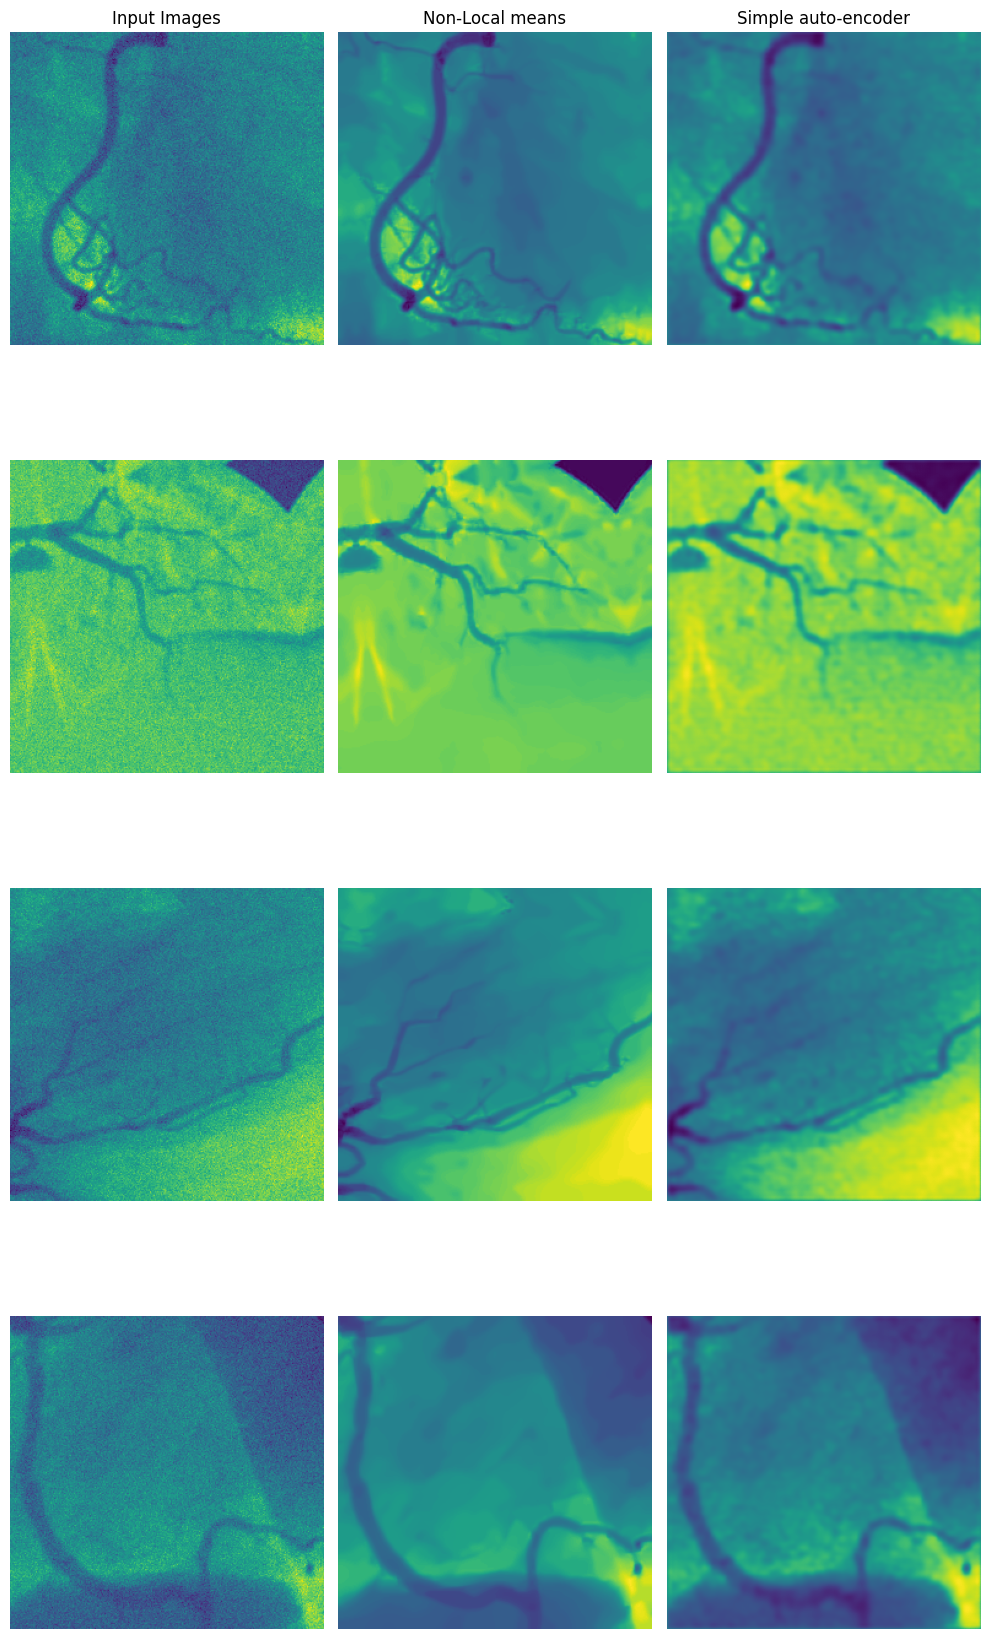

In [ ]:
# from keras.models import load_model
# best_model = load_model("/content/gdrive/MyDrive/ProCom/Code/Model/Denoising_First_Approach.h5",
#                         custom_objects={'categorical_focal_loss_plus_dice_loss': total_loss, "iou_score": sm.metrics.IOUScore(), "f1-score": sm.metrics.FScore()})
fig, ax = plt.subplots(4, 2 + len(models), figsize=(10, 18))
train_id=2
img_s= custom_gen_test[train_id]
print(type(img_s[0][1].astype(np.float32)[0,0,0]))
for i in range(4):
  ax[i, 0].imshow(img_s[0][i])
  ax[i, 0].axis('off')
  # print(cv2.cvtColor(img_s[0][i], cv2.COLOR_GRAY2RGB).type())
  ax[i, 1].imshow(cv2.cvtColor(cv2.fastNlMeansDenoisingColored(np.uint8(cv2.cvtColor(img_s[1][i].astype(np.float32), cv2.COLOR_GRAY2BGR)*256), h = 1.5), cv2.COLOR_BGR2GRAY))
  ax[i, 1].axis('off')
  if(i==0):
    ax[i, 0].set_title("Input Images")
    ax[i, 1].set_title("Non-Local means")
nb_model = 0
for model in models:
  # Get the predicted output for the train set
  y_pred = model.predict(img_s[0])
  for i in range(4):
    ax[i, nb_model + 2].imshow(y_pred[i])
    ax[i, nb_model + 2].axis('off')
    if i == 0:
      if nb_model == 0:
        ax[i, nb_model + 2].set_title("Simple auto-encoder")
      else:
        ax[i, nb_model + 2].set_title("Auto-encoder with \nshorcut connections")
  nb_model += 1

plt.tight_layout()

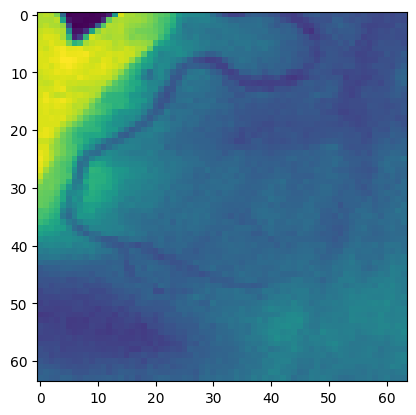

In [ ]:
plt.imshow(custom_gen_train[1][0][0])

In [ ]:
fig, ax = plt.subplots(4, 2 + len(models), figsize=(10, 18))
train_id=2
img_s= custom_gen_test[train_id]
print(type(img_s[0][1].astype(np.float32)[0,0,0]))
for i in range(4):
  ax[i, 0].imshow(img_s[0][i])
  ax[i, 0].axis('off')
  # print(cv2.cvtColor(img_s[0][i], cv2.COLOR_GRAY2RGB).type())
  #ax[i, 1].imshow(cv2.cvtColor(cv2.fastNlMeansDenoisingColored(np.uint8(cv2.cvtColor(img_s[1][i].astype(np.float32), cv2.COLOR_GRAY2BGR)*256), h = 1.5), cv2.COLOR_BGR2GRAY))
  ax[i, 1].axis('off')
  if(i==0):
    ax[i, 0].set_title("Input Images")
    ax[i, 1].set_title("Non-Local means")
nb_model = 0
for model in models:
  # Get the predicted output for the train set
  y_pred = model.predict(img_s[0])
  for i in range(4):
    ax[i, nb_model + 2].imshow(y_pred[i])
    ax[i, nb_model + 2].axis('off')
    if i == 0:
      if nb_model == 0:
        ax[i, nb_model + 2].set_title("Simple auto-encoder")
      else:
        ax[i, nb_model + 2].set_title("Auto-encoder with \nshorcut connections")
  nb_model += 1

plt.tight_layout()

<class 'numpy.float32'>
1/1 [==============================] - 0s 162ms/step


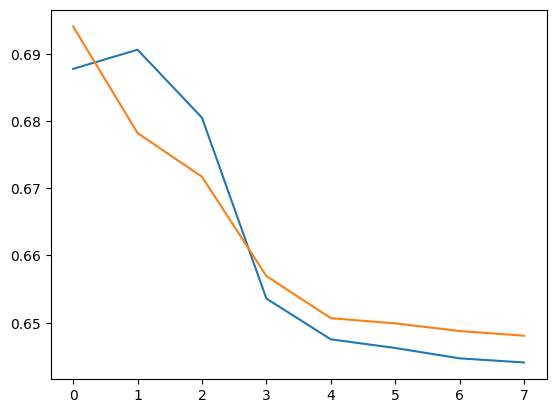

In [ ]:
plt.plot(history.history.get('loss'))
plt.plot(history.history.get('val_loss'))


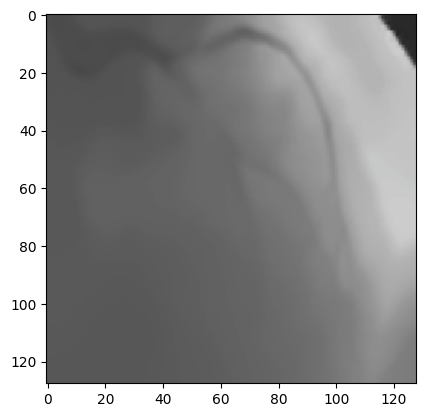

In [ ]:
plt.imshow(cv2.fastNlMeansDenoisingColored(np.uint8(cv2.cvtColor(img_s[0][1], cv2.COLOR_GRAY2BGR)*256)))

In [ ]:
np.uint8(cv2.cvtColor(img_s[0][1], cv2.COLOR_GRAY2BGR)*256)

array([[[ 74,  74,  74],
        [ 74,  74,  74],
        [ 74,  74,  74],
        ...,
        [ 40,  40,  40],
        [ 38,  38,  38],
        [ 43,  43,  43]],

       [[ 76,  76,  76],
        [ 76,  76,  76],
        [ 75,  75,  75],
        ...,
        [ 38,  38,  38],
        [ 41,  41,  41],
        [ 42,  42,  42]],

       [[ 80,  80,  80],
        [ 77,  77,  77],
        [ 74,  74,  74],
        ...,
        [ 42,  42,  42],
        [ 42,  42,  42],
        [ 42,  42,  42]],

       ...,

       [[ 88,  88,  88],
        [ 88,  88,  88],
        [ 88,  88,  88],
        ...,
        [124, 124, 124],
        [122, 122, 122],
        [121, 121, 121]],

       [[ 87,  87,  87],
        [ 88,  88,  88],
        [ 88,  88,  88],
        ...,
        [124, 124, 124],
        [122, 122, 122],
        [120, 120, 120]],

       [[ 86,  86,  86],
        [ 87,  87,  87],
        [ 87,  87,  87],
        ...,
        [123, 123, 123],
        [121, 121, 121],
        [119, 119, 119]]

In [ ]:
# type(cv2.cvtColor(img_s[0][1], cv2.COLOR_GRAY2BGR))
type(noisy_image)

numpy.ndarray

In [ ]:
m = tf.keras.metrics.Accuracy()
images = custom_gen_train[1]

m.update_state(y_true = images[0][0], y_pred = images[0][0] + np.transpose([np.eye(len(images[0][0]))]))
m.result().numpy()

0.9921875

In [ ]:
np.eye(len(images[0][0])).shape
images[0][1].shape

(128, 128, 1)

# PCA Analysis on the dataset

Idea : Find the number of parameter necessary to reconstruct the image correctly

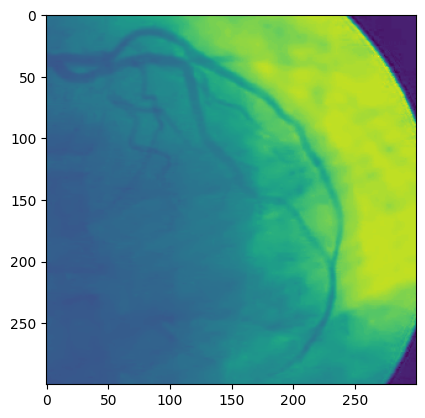

In [ ]:
nb_imgs = len(train_img)
res = len(cv2.imread(f'{img_folder_path}/{train_img[0]}'))

images = np.zeros((res, res, nb_imgs))

for i, img_path in enumerate(train_img):
  images[:, :, i] = cv2.imread(f'{img_folder_path}/{img_path}', cv2.IMREAD_GRAYSCALE)

plt.imshow(images[:,:,1])


In [ ]:
images_vector = np.reshape(images, (res*res, nb_imgs))
emp_cov = np.cov(images_vector)
print(emp_cov.shape)
plt.imshow(emp_cov[1800:2000,1800:2000], cmap = "binary")